In [1]:
import json

import numpy as np
import pandas as pd
import pymongo
import scipy
from bson import ObjectId, json_util
from pandas.io.json import json_normalize
from pymongo import MongoClient as Connection
from scipy import sparse, spatial
from scipy.spatial.distance import cdist, pdist, squareform
from sklearn.metrics.pairwise import cosine_similarity

# scientific notation disabled form smaller numbers
pd.options.display.float_format = '{:.5f}'.format

# alles resultate anzeigen und nicht nur das letzte
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



In [2]:
# display multiple outputs in one row
import pandas as pd
import numpy as np
from IPython.display import display, HTML

CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

In [3]:
connection = Connection()
db = connection.recipe_db
input_data = db.recipes_without_reviews

data = json.loads(json_util.dumps(input_data.find()))

In [4]:
data2 = pd.DataFrame(json_normalize(data))

In [5]:
ing = pd.DataFrame(json_normalize(data, record_path='ingredients',
                             meta='id', record_prefix='ingredients_', errors='ignore'))


nutritions = pd.DataFrame(json_normalize(data, record_path='nutritions',
                            meta=['id', 'prep_time', 'rating', 'rating_count', 'ready_in_time', 'review_count']))


In [6]:
#  ------  erstellung und data cleansing - Ingredients

# schmeiss alle zutaten raus, die weniger als 5 mal verwendet werden
# setze multiinde auf 'id' und 'ingredients_id'
ingredients = ing.set_index(['id', 'ingredients_id'])

# filtere alle Zutaten samt ihrer rezepte id, die weniger gleich 5 mal vorkommen
ingredients_eqles_5_ing = ingredients.groupby(
    'ingredients_id').filter(lambda x: len(x) <= 5)

# droppe alle rezepte, die eine Zutate besitzen, die weniger gleich 5 Mal vorkommen
ingredients_filt = ingredients.drop(ingredients_eqles_5_ing.index.get_level_values('id').values, level=0)

# drop alls rows with ingredients_id == 0
ingredients_eqal_zero = ingredients_filt[ingredients_filt.index.get_level_values('ingredients_id') == 0]
ingredients_filt = ingredients_filt.drop(ingredients_eqal_zero.index.get_level_values('id').values, level=0)


In [7]:
#  ------ Erstellung und cleansing des Nutrition Dataframes

# erstelle neue liste auf basis der bereits gefilterten rezepte aus ingredients_filt
id_overlap_mask = nutritions['id'].isin(ingredients_filt.index.get_level_values('id').values)

# erstelle datenframe auf basis der overlapliste
nutritions_filt = nutritions.loc[id_overlap_mask]

nutrition_db = nutritions_filt.pivot_table(
    index=['id'],
    columns=['name'],
    values=['amount'],
).reset_index()

nutrition_db.set_index('id', inplace=True)

# remove multiindex 'amount'
nutrition_db.columns = nutrition_db.columns.droplevel(0)

# entferne alle NA
nutrition_db = nutrition_db.dropna()

# gleiche nochmals die ids der beiden dataframe nutrition und ingredients ab, da der nutrition dataframe noch NA Werte hatt
id_overlap_mask = ingredients_filt.index.get_level_values('id').isin(nutrition_db.index)
ingredients_db = ingredients_filt[id_overlap_mask]

# abgleich ob anzahl der indizes von nutrition und zutaten dataframe gleich sind


In [8]:


ingredients_db.reset_index(inplace=True)

recipe_db = pd.get_dummies(ingredients_db['ingredients_id']).groupby(
    ingredients_db['id']).apply(max)



In [9]:
new_ingredients = ingredients_db.copy()
#new_ingredients = new_ingredients.groupby("id")["ingredients_grams"].sum().reset_index()
gramms_ingredients = new_ingredients.groupby("id")["ingredients_grams"].sum().reset_index().copy()

Q1 = gramms_ingredients.quantile(0.25)
Q3 = gramms_ingredients.quantile(0.75)
IQR = Q3 - Q1

#Filter out all recipes which are outlier by their weight (gramms)
df = gramms_ingredients[((gramms_ingredients >= (Q1 - 1.5 * IQR))& (gramms_ingredients <= (Q3 + 1.5 * IQR))).all(axis=1)].copy()

#filter out recipes by weight which are not in the range 500 - 2373.59 gramms
df_start_at_fivehundret = df[df['ingredients_grams'].between(500, 2373.58225, inclusive=True)].copy()

df_start_at_fivehundret.set_index('id', inplace=True)
id_overlap_mask = nutritions['id'].isin(df_start_at_fivehundret.index.get_level_values('id').values)


# erstelle datenframe auf basis der overlapliste
nutritions_filt_gramm = nutritions.loc[id_overlap_mask]

nutrition_db2 = nutritions_filt_gramm.pivot_table(
    index=['id'],
    columns=['name'],
    values=['amount'],
).reset_index()

#create new nutrition db based on the above filtering
nutrition_db2.set_index('id', inplace=True)
nutrition_db2.columns = nutrition_db2.columns.droplevel(0)



Text(0.5, 0.98, 'Rezeptgewicht Bereinigung')

/home/daniel/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


{'whiskers': [<matplotlib.lines.Line2D at 0x7fa995344590>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa998b1f9d0>,
 'boxes': [<matplotlib.patches.PathPatch at 0x7fa995336cd0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fa995356b10>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fa995344c50>],
 'means': []}

{'whiskers': [<matplotlib.lines.Line2D at 0x7fa99535db10>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa9952e7590>,
 'boxes': [<matplotlib.patches.PathPatch at 0x7fa995344150>],
 'medians': [<matplotlib.lines.Line2D at 0x7fa9952e7f50>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fa9952f6490>],
 'means': []}

[Text(0, 0, 'Mit Ausreißern \n n = 4062'),
 Text(0, 0, 'Ohne Ausreißer \n n = 3771')]

Text(0, 0.5, 'Rezeptgewicht in Gramm')

([<matplotlib.axis.XTick at 0x7fa99538f190>,
 <a list of 2 Text xticklabel objects>)

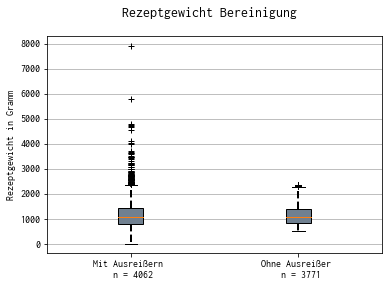

In [10]:
import matplotlib.pyplot as plt
from pylab import *
%matplotlib inline
from matplotlib import rcParams

rcParams['font.family'] = 'Inconsolata'


# figure related code
fig = plt.figure()
fig.suptitle('Rezeptgewicht Bereinigung', fontsize=14, fontweight='medium')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off

ax = fig.add_subplot(111)
ax.boxplot(gramms_ingredients['ingredients_grams'], positions=[1],
            whiskerprops = dict(linestyle='--', linewidth=2), 
            sym="+",
            patch_artist=True,
            boxprops=dict(facecolor='slategrey'),
            #capprops=dict(color=c),
            #flierprops=dict(color=c, markeredgecolor=c)
            #medianprops=dict(color=c),
)
ax.boxplot(df_start_at_fivehundret['ingredients_grams'], positions=[2],
            whiskerprops = dict(linestyle='--', linewidth=2), 
            sym="+",
            patch_artist=True,
            boxprops=dict(facecolor='slategrey'),
            #capprops=dict(color=c),
            #flierprops=dict(color=c, markeredgecolor=c)
            #medianprops=dict(color=c),
)


a=ax.get_xticks().tolist()
a[0]='Mit Ausreißern \n n = 4062'
a[1]='Ohne Ausreißer \n n = 3771'
ax.set_xticklabels(a)

ax.yaxis.grid()
#ax.set_title('n')
#ax.set_xlabel('recipe_grams')
ax.set_ylabel('Rezeptgewicht in Gramm')
plt.xticks([1,2])
plt.flier_props = dict(marker="+", markersize=17)
plt.show()